In [2]:
import sys
sys.path.append("../src")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from exact_solution import solve_master_equation, one_excited_emitter_state

In [4]:
# mirror swaps, 3 runs of 2000 shots
run1 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities.npy', allow_pickle=True) 
run2 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (1).npy', allow_pickle=True)
run3 = np.load('../data/QSCOUT/mirror_swaps/Experiment Probabilities (1).npy', allow_pickle=True)

lines = []
for timestep in zip(run1, run2, run3):
    timestep_data = {key: _ for key in timestep[0].keys()}
    for key, _ in timestep_data.items():
        timestep_data[key] = (np.mean([timestep[0][key], timestep[1][key], timestep[2][key]]))
    lines.append(timestep_data)
    
qscout_results = pd.DataFrame(lines)

In [5]:
N = 3
g = 2
kappa = 5
times = np.linspace(0, 3, 51)

In [6]:
initial_state = one_excited_emitter_state(N, 1)
qutip_results = solve_master_equation(N, g, kappa, initial_state, times)

In [7]:
qscout_bitstrs = {
    "Emitter 1": "1000",
    "Emitter 2": "0100",
    "Emitter 3": "0010",
    "Cavity + Environment": "0001",
}

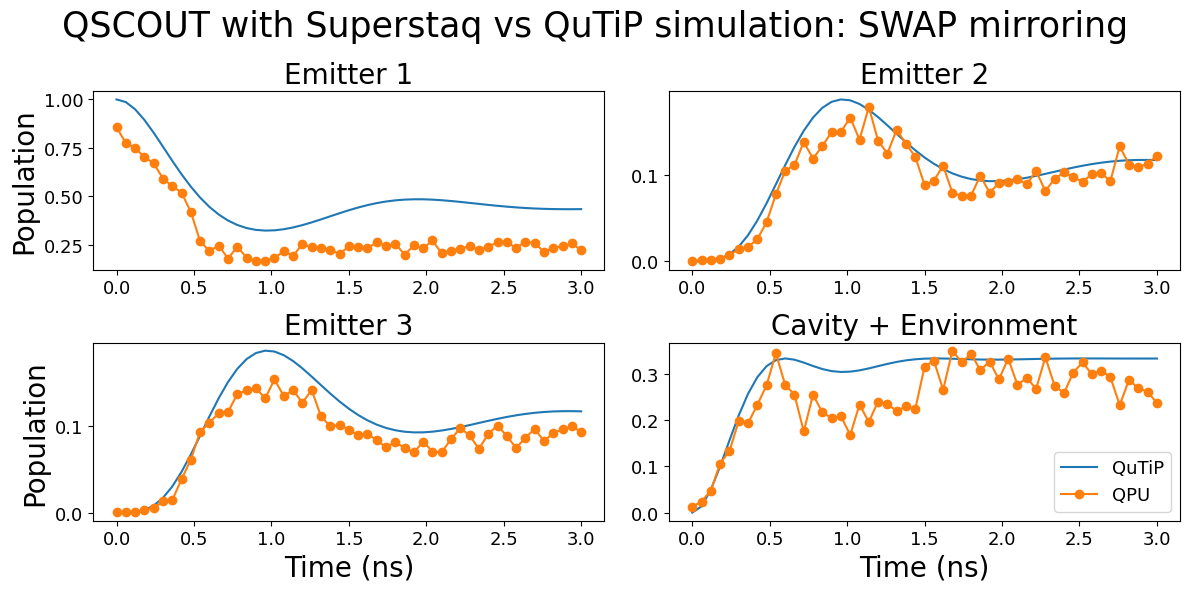

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

for a, column in zip(axes.flatten(), qscout_bitstrs.keys()):
    a.set_title(column, fontsize=20)
    a.plot(qutip_results.index, qutip_results[column], label="QuTiP")

    qscout_normalized_avged = qscout_results
    qscout_column = qscout_bitstrs[column]
    a.plot(times, qscout_normalized_avged[qscout_column], marker='o', label="QPU")

    a.tick_params(axis='x', labelsize=13)
    a.tick_params(axis='y', labelsize=13)

axes[1][0].set_xlabel("Time (ns)", fontsize=20)
axes[1][1].set_xlabel("Time (ns)", fontsize=20)

axes[0][0].set_ylabel("Population", fontsize=20)
axes[1][0].set_ylabel("Population", fontsize=20)

axes[1][1].legend(fontsize=13)

fig.suptitle("QSCOUT with Superstaq vs QuTiP simulation: SWAP mirroring", fontsize=25)
plt.tight_layout()

In [9]:
fig.savefig("../figures/QSCOUT_mirror_swaps.eps")